In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
cp  /content/drive/MyDrive/Kaggle_Api/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download patrickb1912/ipl-complete-dataset-20082020

Dataset URL: https://www.kaggle.com/datasets/patrickb1912/ipl-complete-dataset-20082020
License(s): DbCL-1.0


In [7]:
! unzip ipl-complete-dataset-20082020.zip

Archive:  ipl-complete-dataset-20082020.zip
  inflating: deliveries.csv          
  inflating: matches.csv             


# **# Step 1: Load and Clean the Data**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


df = pd.read_csv('matches.csv')
# Let's examine the basic properties of the dataset

# Display the first few rows
print("First 5 rows:")
print(df.head())

# Ensure date is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract year from date for additional analysis
df['year'] = df['date'].dt.year

# Handle missing values
df['player_of_match'].fillna('Not Awarded', inplace=True)
df['city'].fillna('Unknown', inplace=True)
df['winner'].fillna('No Result', inplace=True)

First 5 rows:
       id   season        city        date match_type player_of_match  \
0  335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
1  335983  2007/08  Chandigarh  2008-04-19     League      MEK Hussey   
2  335984  2007/08       Delhi  2008-04-19     League     MF Maharoof   
3  335985  2007/08      Mumbai  2008-04-20     League      MV Boucher   
4  335986  2007/08     Kolkata  2008-04-20     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali              Kings XI Punjab   
2                            Feroz Shah Kotla             Delhi Daredevils   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kolkata Knight Riders   

                         team2                  toss_winner toss_decision  \
0

<ipython-input-10-27e18e9132a3>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['player_of_match'].fillna('Not Awarded', inplace=True)
<ipython-input-10-27e18e9132a3>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

# **Step 2: Basic Exploratory Analysis**

In [11]:

def basic_stats(df):
    """Generate basic statistics about the IPL dataset"""
    print(f"Total matches in dataset: {df.shape[0]}")
    print(f"Seasons covered: {df['season'].nunique()}")
    print(f"Cities where matches were played: {df['city'].nunique()}")
    print(f"Venues used: {df['venue'].nunique()}")
    print(f"Teams that participated: {pd.concat([df['team1'], df['team2']]).nunique()}")

    # Matches per season
    season_counts = df['season'].value_counts().sort_index()
    print("\nMatches per season:")
    print(season_counts)

    # Result types
    result_counts = df['result'].value_counts()
    print("\nResult types:")
    print(result_counts)

    return season_counts, result_counts

# **Step 3: Team Performance Analysis**

In [12]:
def team_performance_analysis(df):
    """Analyze team performance across seasons"""
    # Total wins by team
    team_wins = df['winner'].value_counts()

    # Calculate matches played by each team
    team1_counts = df['team1'].value_counts()
    team2_counts = df['team2'].value_counts()
    matches_played = team1_counts.add(team2_counts, fill_value=0)

    # Calculate win percentage
    win_percentage = (team_wins / matches_played) * 100
    win_percentage = win_percentage.sort_values(ascending=False)

    # Season-wise performance
    seasons = df['season'].unique()
    season_perf = {}

    for season in seasons:
        season_df = df[df['season'] == season]
        season_perf[season] = season_df['winner'].value_counts()

    season_performance = pd.DataFrame(season_perf)
    season_performance.fillna(0, inplace=True)

    return team_wins, win_percentage, season_performance

# **Step 4: Toss Analysis**

In [13]:
def toss_analysis(df):
    """Analyze the impact of winning the toss"""
    # Calculate how often toss winner wins the match
    toss_winner_is_match_winner = df[df['toss_winner'] == df['winner']]
    toss_win_percentage = (len(toss_winner_is_match_winner) / len(df)) * 100

    print(f"Toss winners win the match {toss_win_percentage:.2f}% of the time")

    # Break down by toss decision
    toss_decision_counts = df['toss_decision'].value_counts()

    # Success rate when choosing to bat first
    bat_first = df[df['toss_decision'] == 'bat']
    bat_first_win = bat_first[bat_first['toss_winner'] == bat_first['winner']]
    bat_first_win_rate = (len(bat_first_win) / len(bat_first)) * 100

    # Success rate when choosing to field first
    field_first = df[df['toss_decision'] == 'field']
    field_first_win = field_first[field_first['toss_winner'] == field_first['winner']]
    field_first_win_rate = (len(field_first_win) / len(field_first)) * 100

    print(f"When choosing to bat first, toss winners win {bat_first_win_rate:.2f}% of the time")
    print(f"When choosing to field first, toss winners win {field_first_win_rate:.2f}% of the time")

    # Toss decision trend over seasons
    toss_by_season = df.groupby(['season', 'toss_decision']).size().unstack()
    toss_by_season['bat_percentage'] = toss_by_season['bat'] / (toss_by_season['bat'] + toss_by_season['field']) * 100

    return toss_win_percentage, bat_first_win_rate, field_first_win_rate, toss_by_season


# **Step 5: Venue Analysis**

In [14]:
def venue_analysis(df):
    """Analyze match patterns across different venues"""
    # Matches per venue
    venue_counts = df['venue'].value_counts()

    # Average target runs by venue (for completed innings)
    venue_runs = df.groupby('venue')['target_runs'].mean().sort_values(ascending=False)

    # Batting first vs fielding first success by venue
    venues = df['venue'].unique()
    venue_stats = []

    for venue in venues:
        venue_matches = df[df['venue'] == venue]
        if len(venue_matches) < 5:  # Skip venues with too few matches
            continue

        # Calculate batting first win percentage
        batting_first_wins = venue_matches[
            ((venue_matches['toss_decision'] == 'bat') & (venue_matches['toss_winner'] == venue_matches['winner'])) |
            ((venue_matches['toss_decision'] == 'field') & (venue_matches['toss_winner'] != venue_matches['winner']))
        ]
        batting_first_win_pct = len(batting_first_wins) / len(venue_matches) * 100

        venue_stats.append({
            'venue': venue,
            'matches': len(venue_matches),
            'avg_target': venue_matches['target_runs'].mean(),
            'batting_first_win_pct': batting_first_win_pct,
            'fielding_first_win_pct': 100 - batting_first_win_pct
        })

    venue_df = pd.DataFrame(venue_stats).sort_values('batting_first_win_pct', ascending=False)
    return venue_counts, venue_runs, venue_df

# **Step 6: Player Analysis**

In [15]:
def player_analysis(df):
    """Analyze player performance based on Player of the Match awards"""
    # Most Player of the Match awards
    pom_counts = df['player_of_match'].value_counts().head(15)

    # Player of the Match by season
    pom_by_season = df.groupby(['season', 'player_of_match']).size().unstack(fill_value=0)

    # Calculate consistency (players who won across multiple seasons)
    player_seasons = df.groupby('player_of_match')['season'].nunique()
    most_consistent = player_seasons.sort_values(ascending=False).head(10)

    return pom_counts, player_seasons

# **Step 7: Match Characteristics Analysis**

In [16]:
def match_characteristics(df):
    """Analyze characteristics of matches like margins, high scores, etc."""
    # Distribution of win by runs vs win by wickets
    win_type_counts = df['result'].value_counts()

    # Average winning margin by runs
    runs_wins = df[df['result'] == 'runs']
    avg_runs_margin = runs_wins['result_margin'].mean()

    # Average winning margin by wickets
    wicket_wins = df[df['result'] == 'wickets']
    avg_wicket_margin = wicket_wins['result_margin'].mean()

    # Highest team scores (approximated from target_runs)
    # Note: This is an approximation as we're using target_runs
    highest_targets = df.sort_values('target_runs', ascending=False)[['season', 'team1', 'team2', 'target_runs']].head(10)

    # Close matches (small margins)
    close_run_matches = runs_wins.sort_values('result_margin').head(10)
    last_ball_finishes = wicket_wins[(wicket_wins['result_margin'] <= 2) & (wicket_wins['target_overs'] - 0.1 <= 0.5)]

    return avg_runs_margin, avg_wicket_margin, highest_targets, close_run_matches

# **Step 8: Time Series Analysis**

In [17]:
def time_series_analysis(df):
    """Analyze trends over time in the IPL"""
    # Average target scores by season
    season_avg_target = df.groupby('season')['target_runs'].mean()

    # Match results by type over seasons
    result_by_season = df.groupby(['season', 'result']).size().unstack(fill_value=0)

    # Toss impact over seasons
    seasons = df['season'].unique()
    toss_impact = []

    for season in seasons:
        season_df = df[df['season'] == season]
        toss_winners_won = season_df[season_df['toss_winner'] == season_df['winner']]
        toss_impact.append({
            'season': season,
            'toss_win_pct': len(toss_winners_won) / len(season_df) * 100
        })

    toss_impact_df = pd.DataFrame(toss_impact)

    return season_avg_target, result_by_season, toss_impact_df

# **Step 9: Advanced Analysis - Clustering Venues**

In [18]:
def cluster_venues(df):
    """Use K-means clustering to group similar venues"""
    # Create venue feature matrix
    venues = df['venue'].unique()
    venue_features = []

    for venue in venues:
        venue_matches = df[df['venue'] == venue]

        if len(venue_matches) < 5:  # Skip venues with few matches
            continue

        # Calculate venue characteristics
        avg_target = venue_matches['target_runs'].mean()
        batting_first_wins = venue_matches[
            ((venue_matches['toss_decision'] == 'bat') & (venue_matches['toss_winner'] == venue_matches['winner'])) |
            ((venue_matches['toss_decision'] == 'field') & (venue_matches['toss_winner'] != venue_matches['winner']))
        ]
        batting_win_pct = len(batting_first_wins) / len(venue_matches) * 100

        venue_features.append({
            'venue': venue,
            'matches': len(venue_matches),
            'avg_target': avg_target,
            'batting_first_win_pct': batting_win_pct
        })

    venue_df = pd.DataFrame(venue_features)

    # Prepare data for clustering
    X = venue_df[['avg_target', 'batting_first_win_pct']].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Use elbow method to find optimal number of clusters
    inertia = []
    for k in range(1, min(10, len(X))):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # Choose number of clusters (in a real analysis, you would visualize inertia)
    k = 3  # This can be adjusted based on the elbow curve

    # Perform clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    venue_df['cluster'] = kmeans.fit_predict(X_scaled)

    # Interpret clusters
    cluster_summary = venue_df.groupby('cluster')[['avg_target', 'batting_first_win_pct']].mean()

    return venue_df, cluster_summary, inertia

# **Step 10: Predictive Modeling**

In [19]:
def build_predictive_model(df):
    """Build a model to predict match winners"""
    # Create features for prediction
    model_df = df.copy()

    # Filter to matches with clear outcomes
    model_df = model_df[model_df['winner'].notna()]

    # Calculate team strengths based on past performance
    team_win_pcts = {}
    teams = pd.concat([df['team1'], df['team2']]).unique()

    for team in teams:
        team_matches = df[(df['team1'] == team) | (df['team2'] == team)]
        if len(team_matches) == 0:
            team_win_pcts[team] = 0.5  # Default
            continue

        team_wins = team_matches[team_matches['winner'] == team]
        win_pct = len(team_wins) / len(team_matches)
        team_win_pcts[team] = win_pct

    # Add team strength features
    model_df['team1_strength'] = model_df['team1'].map(team_win_pcts)
    model_df['team2_strength'] = model_df['team2'].map(team_win_pcts)

    # Add venue familiarity
    # For each team and venue, calculate win percentage
    venue_team_stats = {}

    for team in teams:
        for venue in df['venue'].unique():
            team_venue_matches = df[((df['team1'] == team) | (df['team2'] == team)) & (df['venue'] == venue)]
            if len(team_venue_matches) < 2:  # Not enough matches
                venue_team_stats[(team, venue)] = 0.5  # Default
                continue

            team_venue_wins = team_venue_matches[team_venue_matches['winner'] == team]
            win_pct = len(team_venue_wins) / len(team_venue_matches)
            venue_team_stats[(team, venue)] = win_pct

    # Add toss features
    model_df['team1_won_toss'] = (model_df['team1'] == model_df['toss_winner']).astype(int)
    model_df['toss_decision_bat'] = (model_df['toss_decision'] == 'bat').astype(int)

    # Create target variable
    model_df['team1_won'] = (model_df['team1'] == model_df['winner']).astype(int)

    # Select features for model
    features = [
        'team1_strength', 'team2_strength',
        'team1_won_toss', 'toss_decision_bat'
    ]

    # Add venue familiarity features
    model_df['team1_venue_familiarity'] = model_df.apply(
        lambda row: venue_team_stats.get((row['team1'], row['venue']), 0.5), axis=1
    )
    model_df['team2_venue_familiarity'] = model_df.apply(
        lambda row: venue_team_stats.get((row['team2'], row['venue']), 0.5), axis=1
    )

    features.extend(['team1_venue_familiarity', 'team2_venue_familiarity'])

    # Split data
    X = model_df[features]
    y = model_df['team1_won']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Train random forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Evaluate model
    train_acc = rf.score(X_train, y_train)
    test_acc = rf.score(X_test, y_test)

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    return train_acc, test_acc, feature_importance

# **Step 11: Visualization Functions**

Starting comprehensive IPL analysis...
Total matches in dataset: 1095
Seasons covered: 17
Cities where matches were played: 37
Venues used: 58
Teams that participated: 19

Matches per season:
season
2007/08    58
2009       57
2009/10    60
2011       73
2012       74
2013       76
2014       60
2015       59
2016       60
2017       59
2018       60
2019       60
2020/21    60
2021       60
2022       74
2023       74
2024       71
Name: count, dtype: int64

Result types:
result
wickets      578
runs         498
tie           14
no result      5
Name: count, dtype: int64

Top teams by win percentage:
Rising Pune Supergiant    62.500000
Gujarat Titans            62.222222
Chennai Super Kings       57.983193
Mumbai Indians            55.172414
Lucknow Super Giants      54.545455
Name: count, dtype: float64
Toss winners win the match 50.59% of the time
When choosing to bat first, toss winners win 45.27% of the time
When choosing to field first, toss winners win 53.55% of the time

Top ve

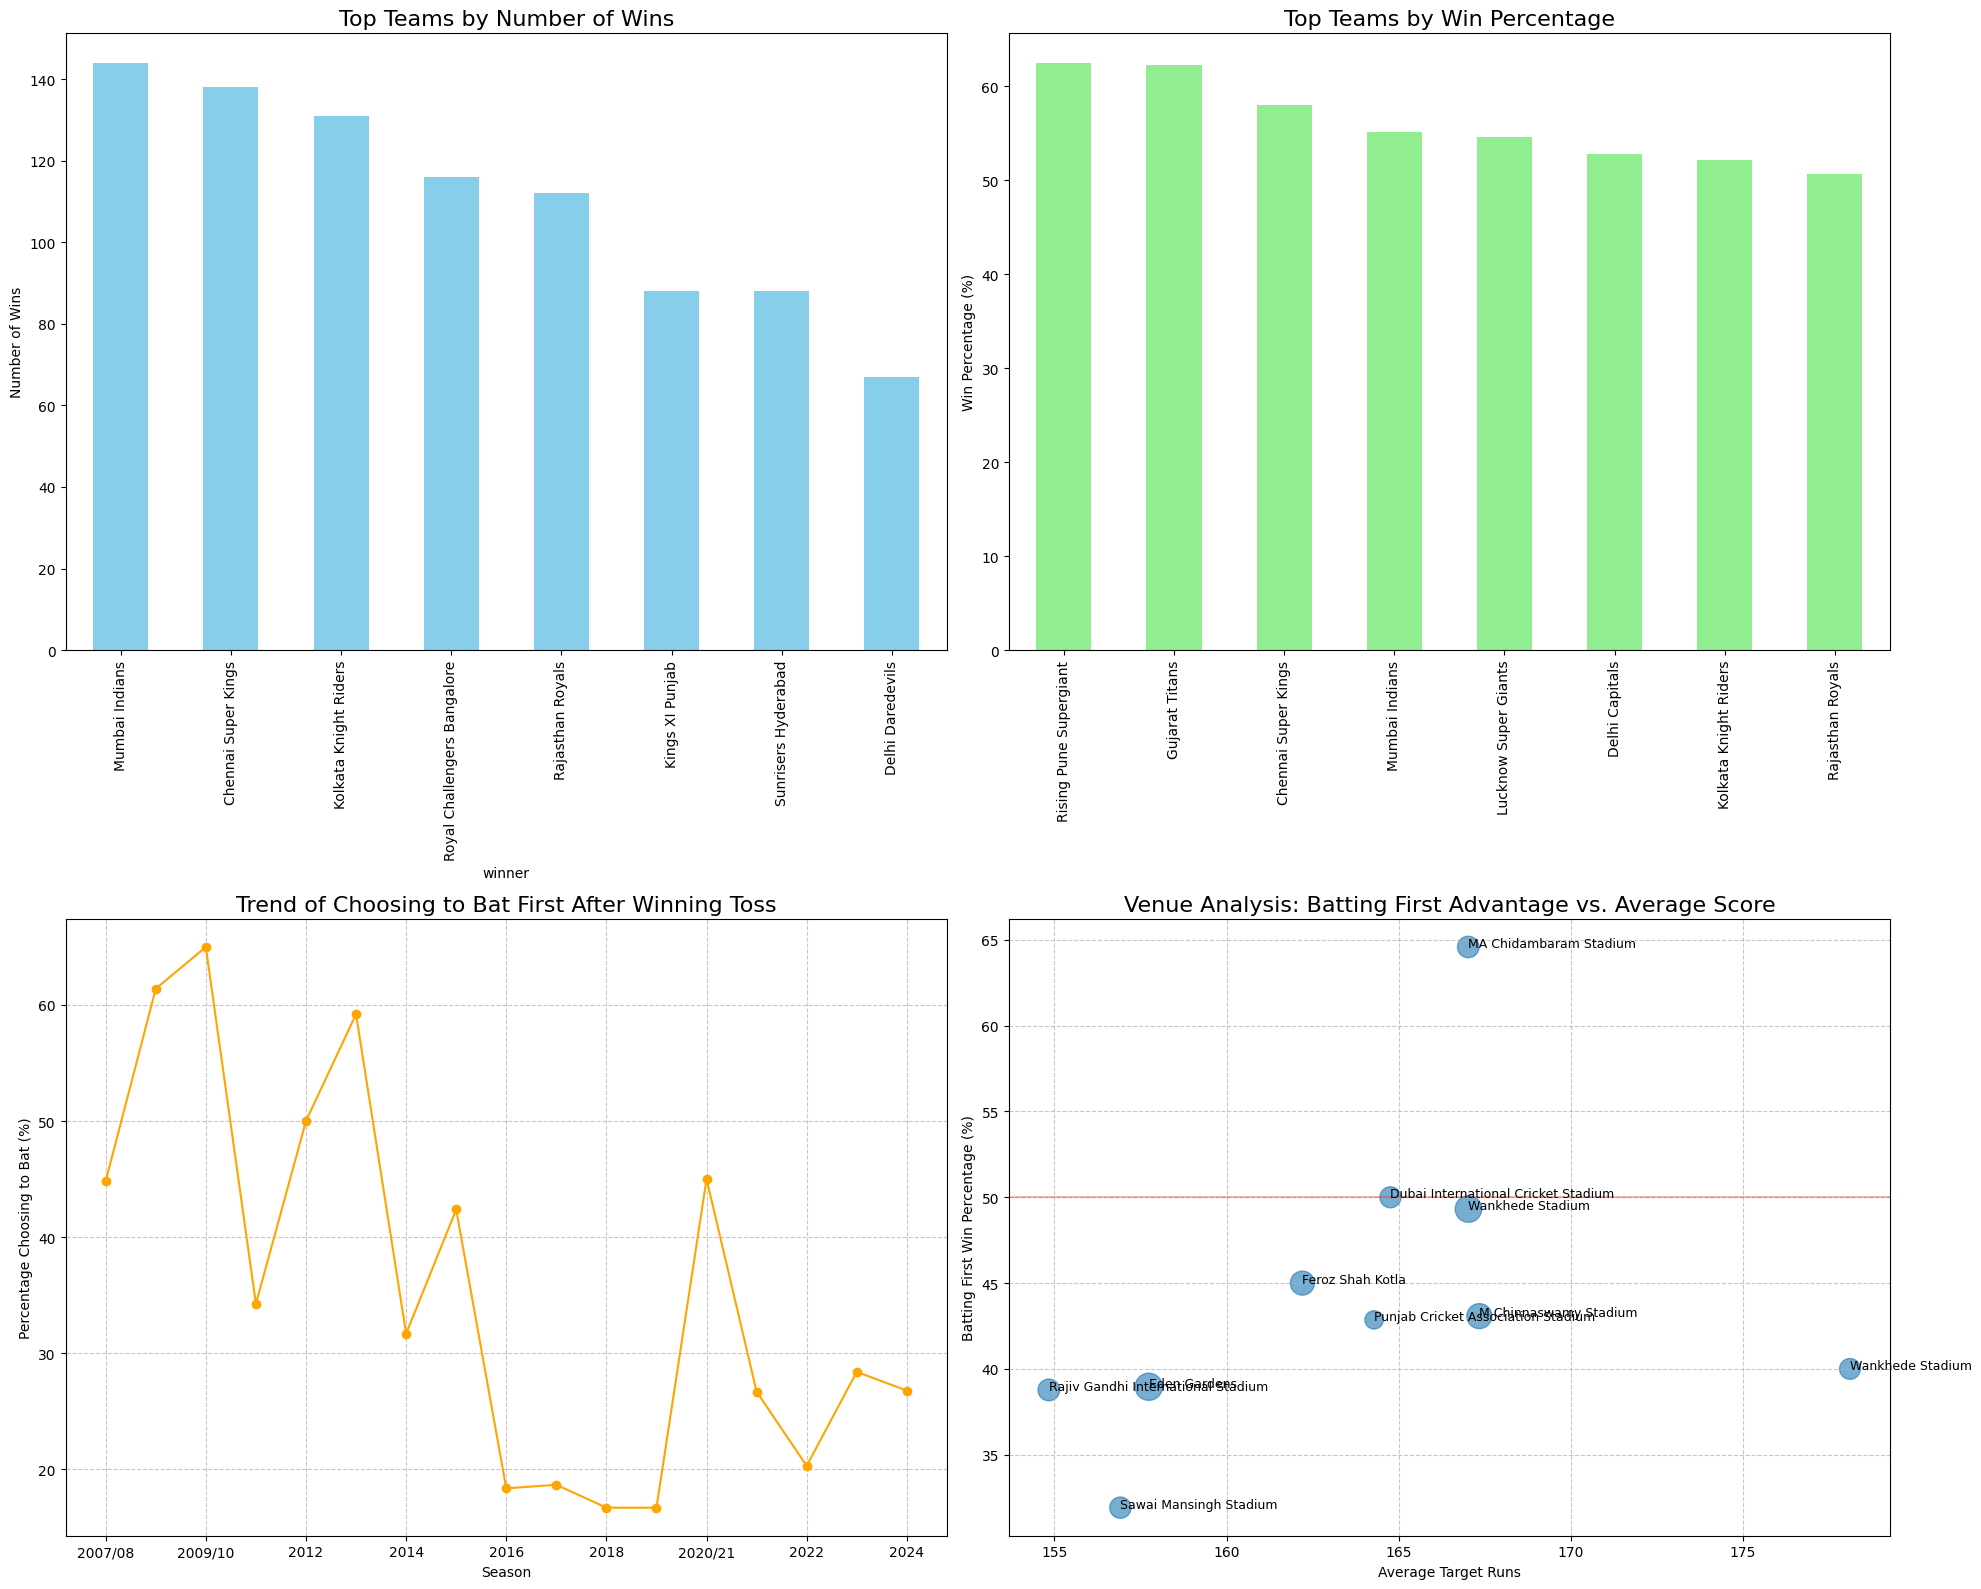

In [21]:
def create_visualizations(df, team_wins, win_percentage, toss_by_season, venue_df):
    """Create key visualizations for IPL analysis"""
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # 1. Team wins bar chart
    top_teams = team_wins.head(8)
    top_teams.plot(kind='bar', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Top Teams by Number of Wins', fontsize=16)
    axes[0, 0].set_ylabel('Number of Wins')

    # 2. Win percentage bar chart
    win_percentage.head(8).plot(kind='bar', ax=axes[0, 1], color='lightgreen')
    axes[0, 1].set_title('Top Teams by Win Percentage', fontsize=16)
    axes[0, 1].set_ylabel('Win Percentage (%)')

    # 3. Toss decision trend over seasons
    if isinstance(toss_by_season, pd.DataFrame) and 'bat_percentage' in toss_by_season.columns:
        toss_by_season['bat_percentage'].plot(marker='o', ax=axes[1, 0], color='orange')
        axes[1, 0].set_title('Trend of Choosing to Bat First After Winning Toss', fontsize=16)
        axes[1, 0].set_ylabel('Percentage Choosing to Bat (%)')
        axes[1, 0].set_xlabel('Season')
        axes[1, 0].grid(True, linestyle='--', alpha=0.7)

    # 4. Venue analysis
    if isinstance(venue_df, pd.DataFrame) and 'batting_first_win_pct' in venue_df.columns:
        top_venues = venue_df.sort_values('matches', ascending=False).head(10)
        top_venues.plot.scatter(x='avg_target', y='batting_first_win_pct', s=top_venues['matches']*5,
                               alpha=0.6, ax=axes[1, 1])

        for i, row in top_venues.iterrows():
            axes[1, 1].annotate(row['venue'].split(',')[0],
                             (row['avg_target'], row['batting_first_win_pct']),
                             fontsize=9)

        axes[1, 1].set_title('Venue Analysis: Batting First Advantage vs. Average Score', fontsize=16)
        axes[1, 1].set_xlabel('Average Target Runs')
        axes[1, 1].set_ylabel('Batting First Win Percentage (%)')
        axes[1, 1].grid(True, linestyle='--', alpha=0.7)
        axes[1, 1].axhline(y=50, color='r', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.savefig('ipl_analysis.png')
    return fig

# Run the complete analysis pipeline
def run_complete_analysis(df):
    """Execute the complete analysis pipeline"""
    print("Starting comprehensive IPL analysis...")

    # Basic stats
    season_counts, result_counts = basic_stats(df)

    # Team performance
    team_wins, win_percentage, season_performance = team_performance_analysis(df)
    print("\nTop teams by win percentage:")
    print(win_percentage.head(5))

    # Toss analysis
    toss_win_pct, bat_first_win_rate, field_first_win_rate, toss_by_season = toss_analysis(df)

    # Venue analysis
    venue_counts, venue_runs, venue_df = venue_analysis(df)
    print("\nTop venues by batting first advantage:")
    print(venue_df.head(5)[['venue', 'matches', 'batting_first_win_pct']])

    # Player analysis
    pom_counts, player_seasons = player_analysis(df)
    print("\nTop players by Player of the Match awards:")
    print(pom_counts.head(5))

    # Match characteristics
    avg_runs_margin, avg_wicket_margin, highest_targets, close_matches = match_characteristics(df)
    print(f"\nAverage winning margin by runs: {avg_runs_margin:.2f}")
    print(f"Average winning margin by wickets: {avg_wicket_margin:.2f}")

    # Time series analysis
    season_avg_target, result_by_season, toss_impact_df = time_series_analysis(df)

    # Advanced analysis
    venue_clusters, cluster_summary, inertia = cluster_venues(df)
    print("\nVenue clusters identified:")
    print(cluster_summary)

    # Predictive modeling
    train_acc, test_acc, feature_importance = build_predictive_model(df)
    print(f"\nMatch prediction model accuracy: {test_acc:.2f}")
    print("Most important features for predicting outcomes:")
    print(feature_importance.head())

    # Create visualizations
    fig = create_visualizations(df, team_wins, win_percentage, toss_by_season, venue_df)

    print("\nAnalysis complete!")
    return {
        "team_performance": {
            "wins": team_wins,
            "win_percentage": win_percentage,
            "season_performance": season_performance
        },
        "toss_analysis": {
            "toss_win_pct": toss_win_pct,
            "bat_first_win_rate": bat_first_win_rate,
            "field_first_win_rate": field_first_win_rate
        },
        "venue_analysis": venue_df,
        "player_analysis": pom_counts,
        "prediction_model": {
            "accuracy": test_acc,
            "important_features": feature_importance
        }
    }

# Example usage
results = run_complete_analysis(df)